# Sicily smoking ban analysis

In [2]:
# Imports
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
%matplotlib inline
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings('ignore')
print('imports OK')

imports OK


In [3]:
# Load data
df = pd.read_csv('data/sicily.csv')
df.head()

,year,month,aces,time,smokban,pop,stdpop
0,2002,1,728,1,0,364277.4,379875.3
1,2002,2,659,2,0,364277.4,376495.5
2,2002,3,791,3,0,364277.4,377040.8
3,2002,4,734,4,0,364277.4,377116.4
4,2002,5,757,5,0,364277.4,377383.4


In [4]:
# Basic preprocessing
# detect intervention time (first row where smokban==1)
ban_start_time = int(df[df['smokban'] == 1]['time'].min())
df['time_after_ban'] = (df['time'] - ban_start_time).clip(lower=0) * df['smokban']
# ensure month is categorical for seasonality
if 'month' in df.columns:
    df['month'] = df['month'].astype('category')
# population offset (stdpop) expected in data
if 'stdpop' not in df.columns:
    df['stdpop'] = df.get('pop', 1.0)
df.tail()

,year,month,aces,time,smokban,pop,stdpop,time_after_ban
54,2006,7,810,55,1,363832.6,391878.5,18
55,2006,8,876,56,1,363832.6,388575.3,19
56,2006,9,843,57,1,363832.6,392989.0,20
57,2006,10,936,58,1,363832.6,390018.8,21
58,2006,11,912,59,1,363832.6,390712.3,22


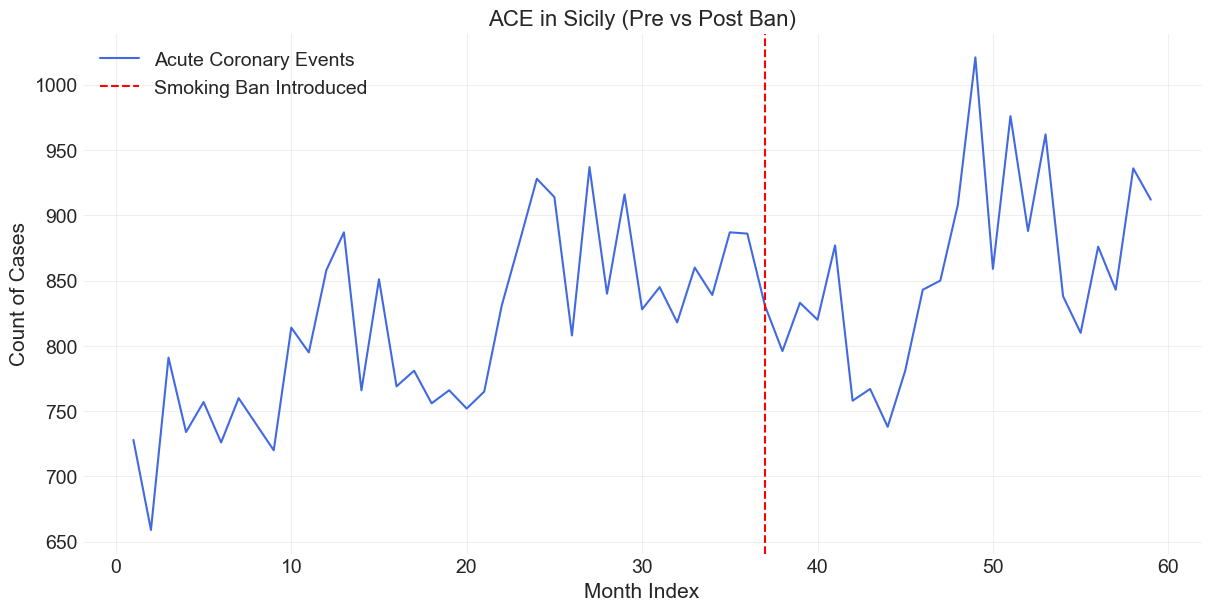

In [5]:
# visualize ace over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='time', y='aces', color='royalblue', label='Acute Coronary Events')
# find the start of the ban
ban_start_time = int(df[df['smokban'] == 1]['time'].min())
plt.axvline(x=ban_start_time, color='red', linestyle='--', label='Smoking Ban Introduced')
plt.title('ACE in Sicily (Pre vs Post Ban)')
plt.xlabel('Month Index')
plt.ylabel('Count of Cases')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

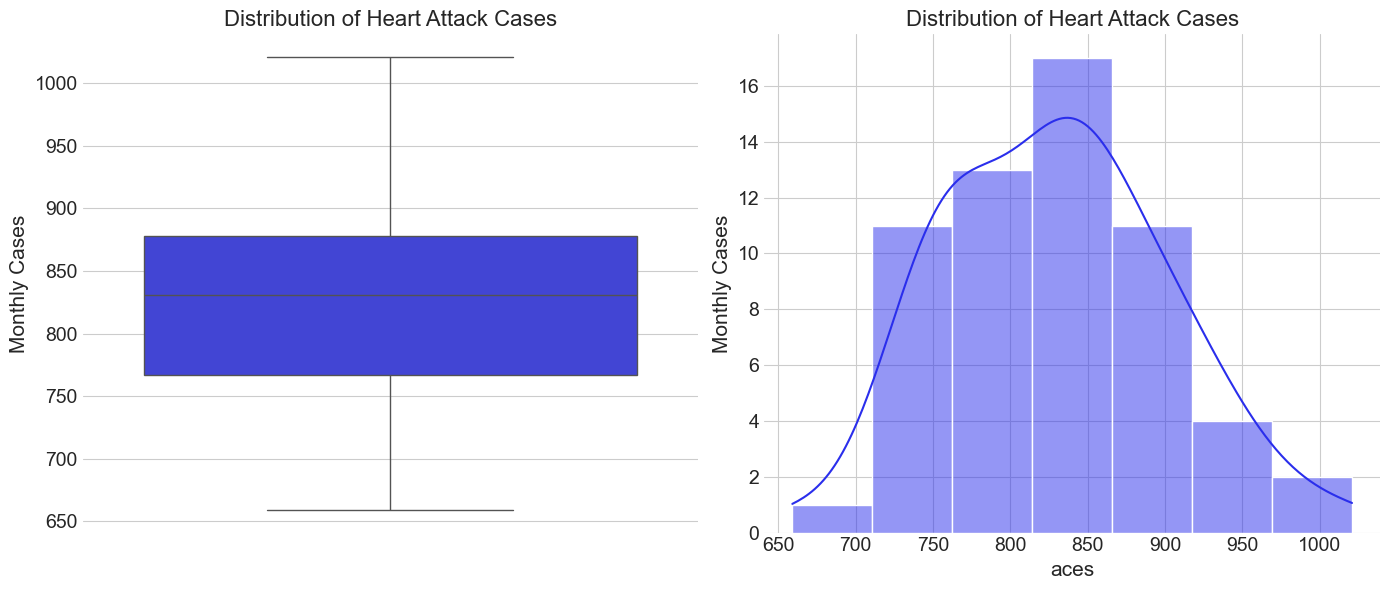

In [6]:
# visualize distribution of ace pre vs post ban
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
sns.boxplot(data=df, y='aces')
plt.title('Distribution of Heart Attack Cases')
plt.ylabel('Monthly Cases')
plt.tight_layout()

plt.subplot(1,2,2)
sns.histplot(data=df, x='aces', kde=True)
plt.title('Distribution of Heart Attack Cases')
plt.ylabel('Monthly Cases')
plt.tight_layout()
plt.show()

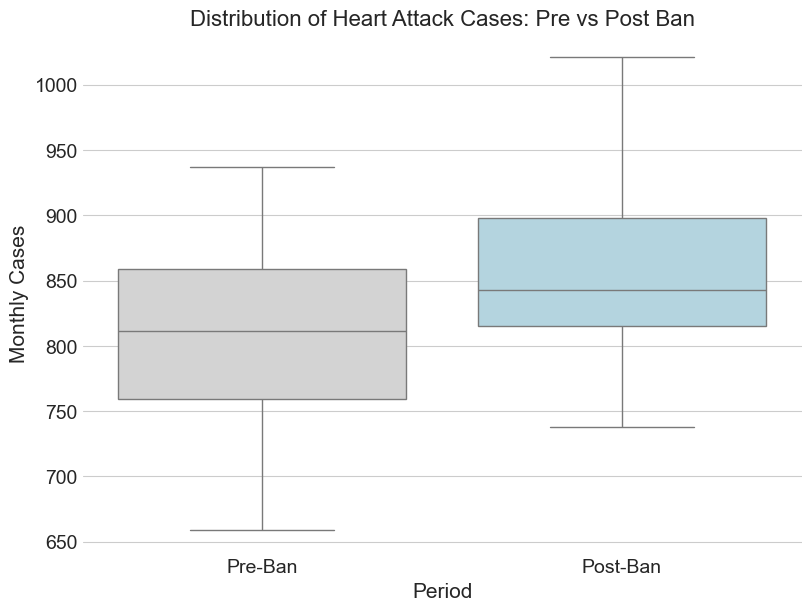

In [7]:
# visualize distribution of ace pre vs post ban
plt.figure(figsize=(8,6))
df['Period'] = df['smokban'].map({0: 'Pre-Ban', 1: 'Post-Ban'})
sns.boxplot(data=df, x='Period', y='aces', palette=['lightgrey','lightblue'])
plt.title('Distribution of Heart Attack Cases: Pre vs Post Ban')
plt.ylabel('Monthly Cases')
plt.show()

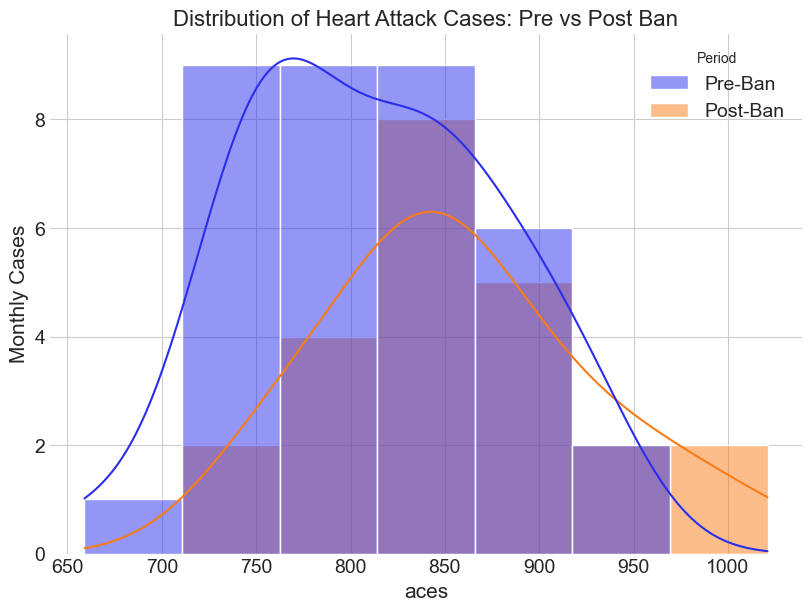

In [8]:
# visualize distribution of ace pre vs post ban
plt.figure(figsize=(8,6))
sns.histplot(data=df, x='aces', hue='Period', kde=True)
plt.title('Distribution of Heart Attack Cases: Pre vs Post Ban')
plt.ylabel('Monthly Cases')
plt.show()

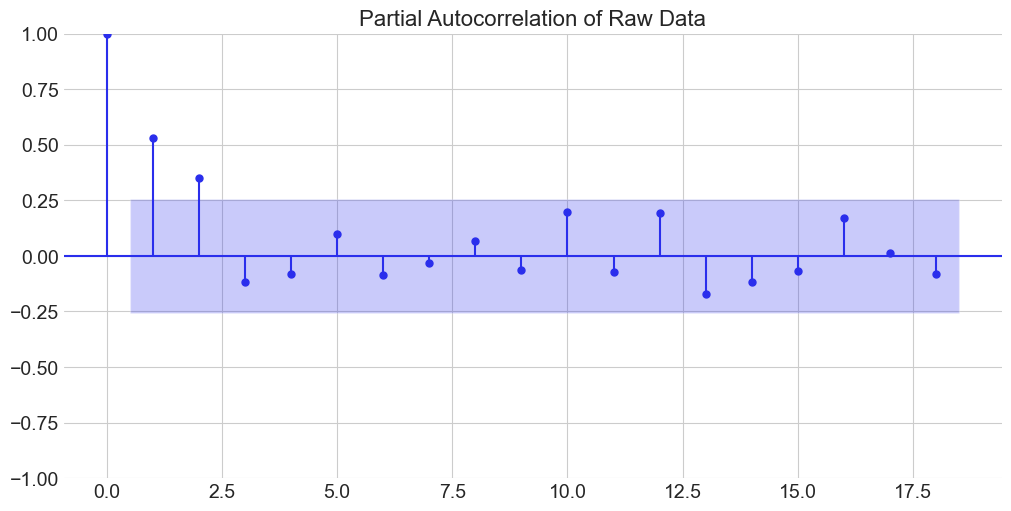

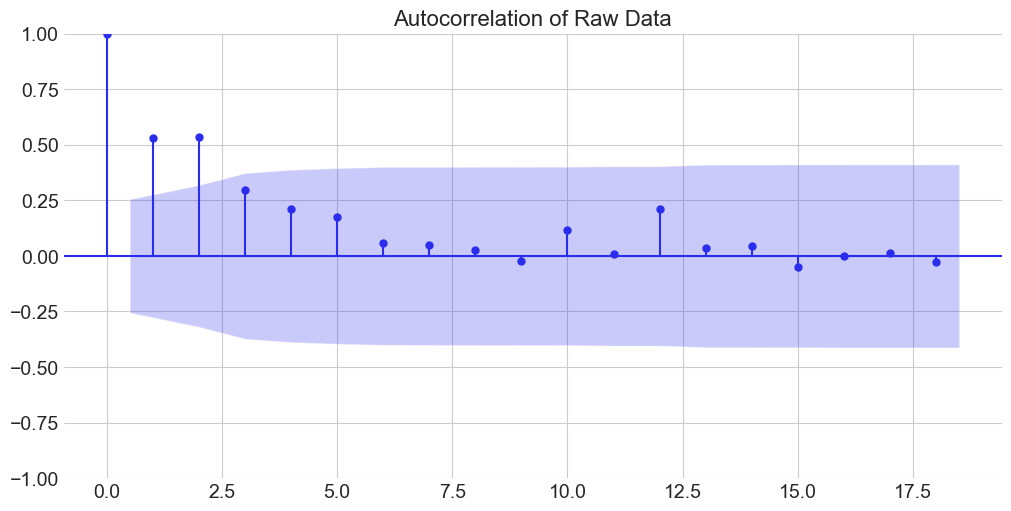

In [10]:
# plot Pacf
fig, ax = plt.subplots(figsize=(10,5))
plot_pacf(df['aces'], ax=ax)
plt.title('Partial Autocorrelation of Raw Data')
plt.show()
# Plot ACF
fig, ax = plt.subplots(figsize=(10,5))
plot_acf(df['aces'], ax=ax)
plt.title('Autocorrelation of Raw Data')
plt.show()

In [12]:
# Design matrix with seasonal dummies
seasonality = pd.get_dummies(df.get('month', pd.Series(dtype='category')), prefix='m', drop_first=True)
df_model = pd.concat([df, seasonality], axis=1)
X_columns = ['time', 'smokban', 'time_after_ban'] + list(seasonality.columns)
# fallback if no seasonality columns
X_columns = [c for c in X_columns if c in df_model.columns]
X_data = df_model[X_columns].astype(float).values
y_data = df_model['aces'].values
log_pop = np.log(df_model['stdpop'].values)
print('Prepared design matrix with columns:', X_columns)

Prepared design matrix with columns: ['time', 'smokban', 'time_after_ban', 'm_2', 'm_3', 'm_4', 'm_5', 'm_6', 'm_7', 'm_8', 'm_9', 'm_10', 'm_11', 'm_12']


In [22]:
# Build PyMC model (Poisson ITS with offset)
with pm.Model() as its_model:
    X_shared = pm.Data('X_data', X_data)
    log_pop_shared = pm.Data('log_pop', log_pop)
    y_shared = pm.Data('y_data', y_data)

    beta0 = pm.Normal('beta0', mu=0, sigma=10)
    betas = pm.Normal('betas', mu=0, sigma=2, shape=X_data.shape[1])

    linpred = beta0 + pm.math.dot(X_shared, betas) + log_pop_shared
    # clip linear predictor to avoid extremely large lambda in prior predictive draws
    mu = pm.math.exp(pm.math.clip(linpred, -20, 20))
    y_obs = pm.Poisson('y_obs', mu=mu, observed=y_shared)

    # prior predictive for checks (reduced draws to avoid extreme samples)
    idata = pm.sample_prior_predictive(samples=2000, return_inferencedata=True)
print('Model built')

Sampling: [beta0, betas, y_obs]


Model built


In [23]:
# Sample posterior (reduce draws for speed; increase for final analysis)
with its_model:
    trace = pm.sample(draws=3000, tune=1000, target_accept=0.95, return_inferencedata=True, progressbar=True, nuts_sampler="numpyro")
    trace.extend(idata)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

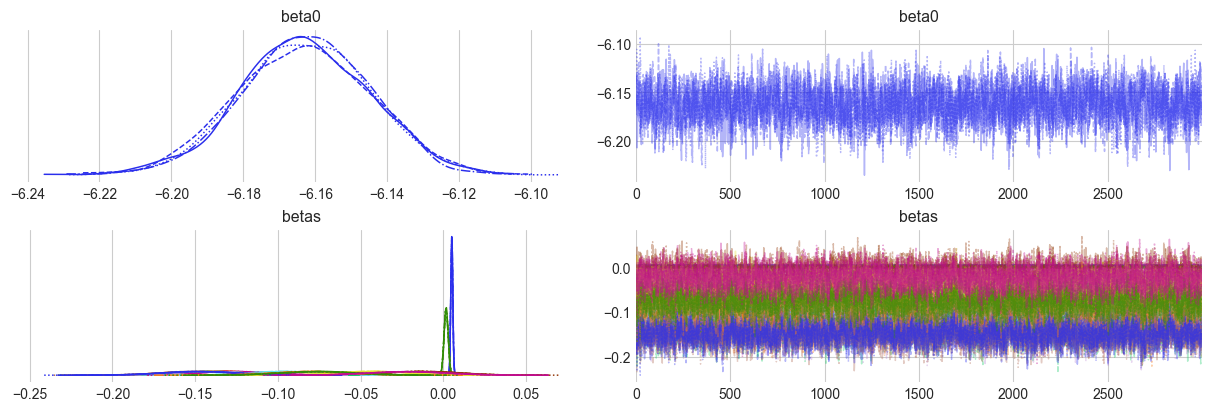

In [24]:
# visualize the conergence
az.plot_trace(trace)
plt.show()

In [25]:
# inspecting summary statistics
summary = az.summary(trace)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,-6.163,0.018,-6.197,-6.129,0.0,0.0,2307.0,3574.0,1.0
betas[0],0.005,0.001,0.004,0.006,0.0,0.0,9357.0,9144.0,1.0
betas[1],-0.134,0.020,-0.172,-0.098,0.0,0.0,5407.0,7601.0,1.0
betas[2],0.002,0.001,-0.001,0.004,0.0,0.0,11735.0,9324.0,1.0
betas[3],-0.126,0.022,-0.167,-0.085,0.0,0.0,2695.0,4703.0,1.0
betas[4],-0.012,0.022,-0.051,0.030,0.0,0.0,2680.0,4507.0,1.0
betas[5],-0.096,0.022,-0.138,-0.056,0.0,0.0,2701.0,5035.0,1.0
betas[6],-0.042,0.022,-0.083,-0.002,0.0,0.0,2654.0,4599.0,1.0
betas[7],-0.141,0.022,-0.182,-0.099,0.0,0.0,2665.0,5139.0,1.0
betas[8],-0.141,0.022,-0.183,-0.099,0.0,0.0,2741.0,5360.0,1.0


<Axes: >

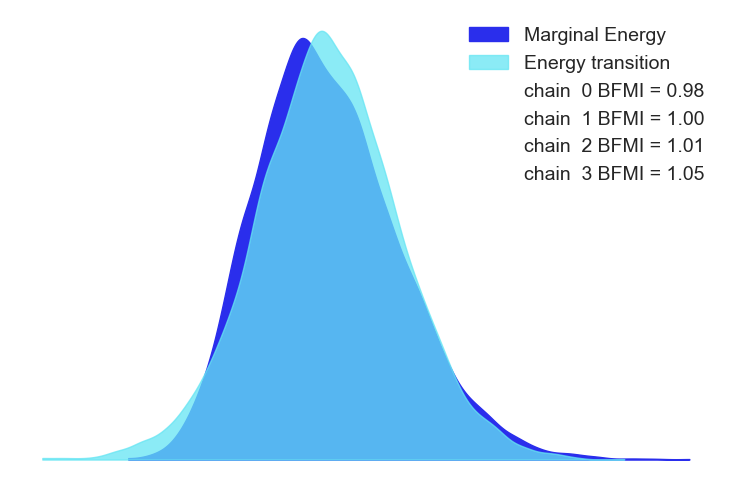

In [26]:
#Inspecting enery plot
az.plot_energy(trace)

array([[<Axes: title={'center': 'beta0'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'betas\n0'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'betas\n1'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'betas\n2'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'betas\n3'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'betas\n4'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'betas\n5'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'betas\n6'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'betas\n7'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'betas\n8'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'betas\n9'}, xlabel='Total number of draws', yla

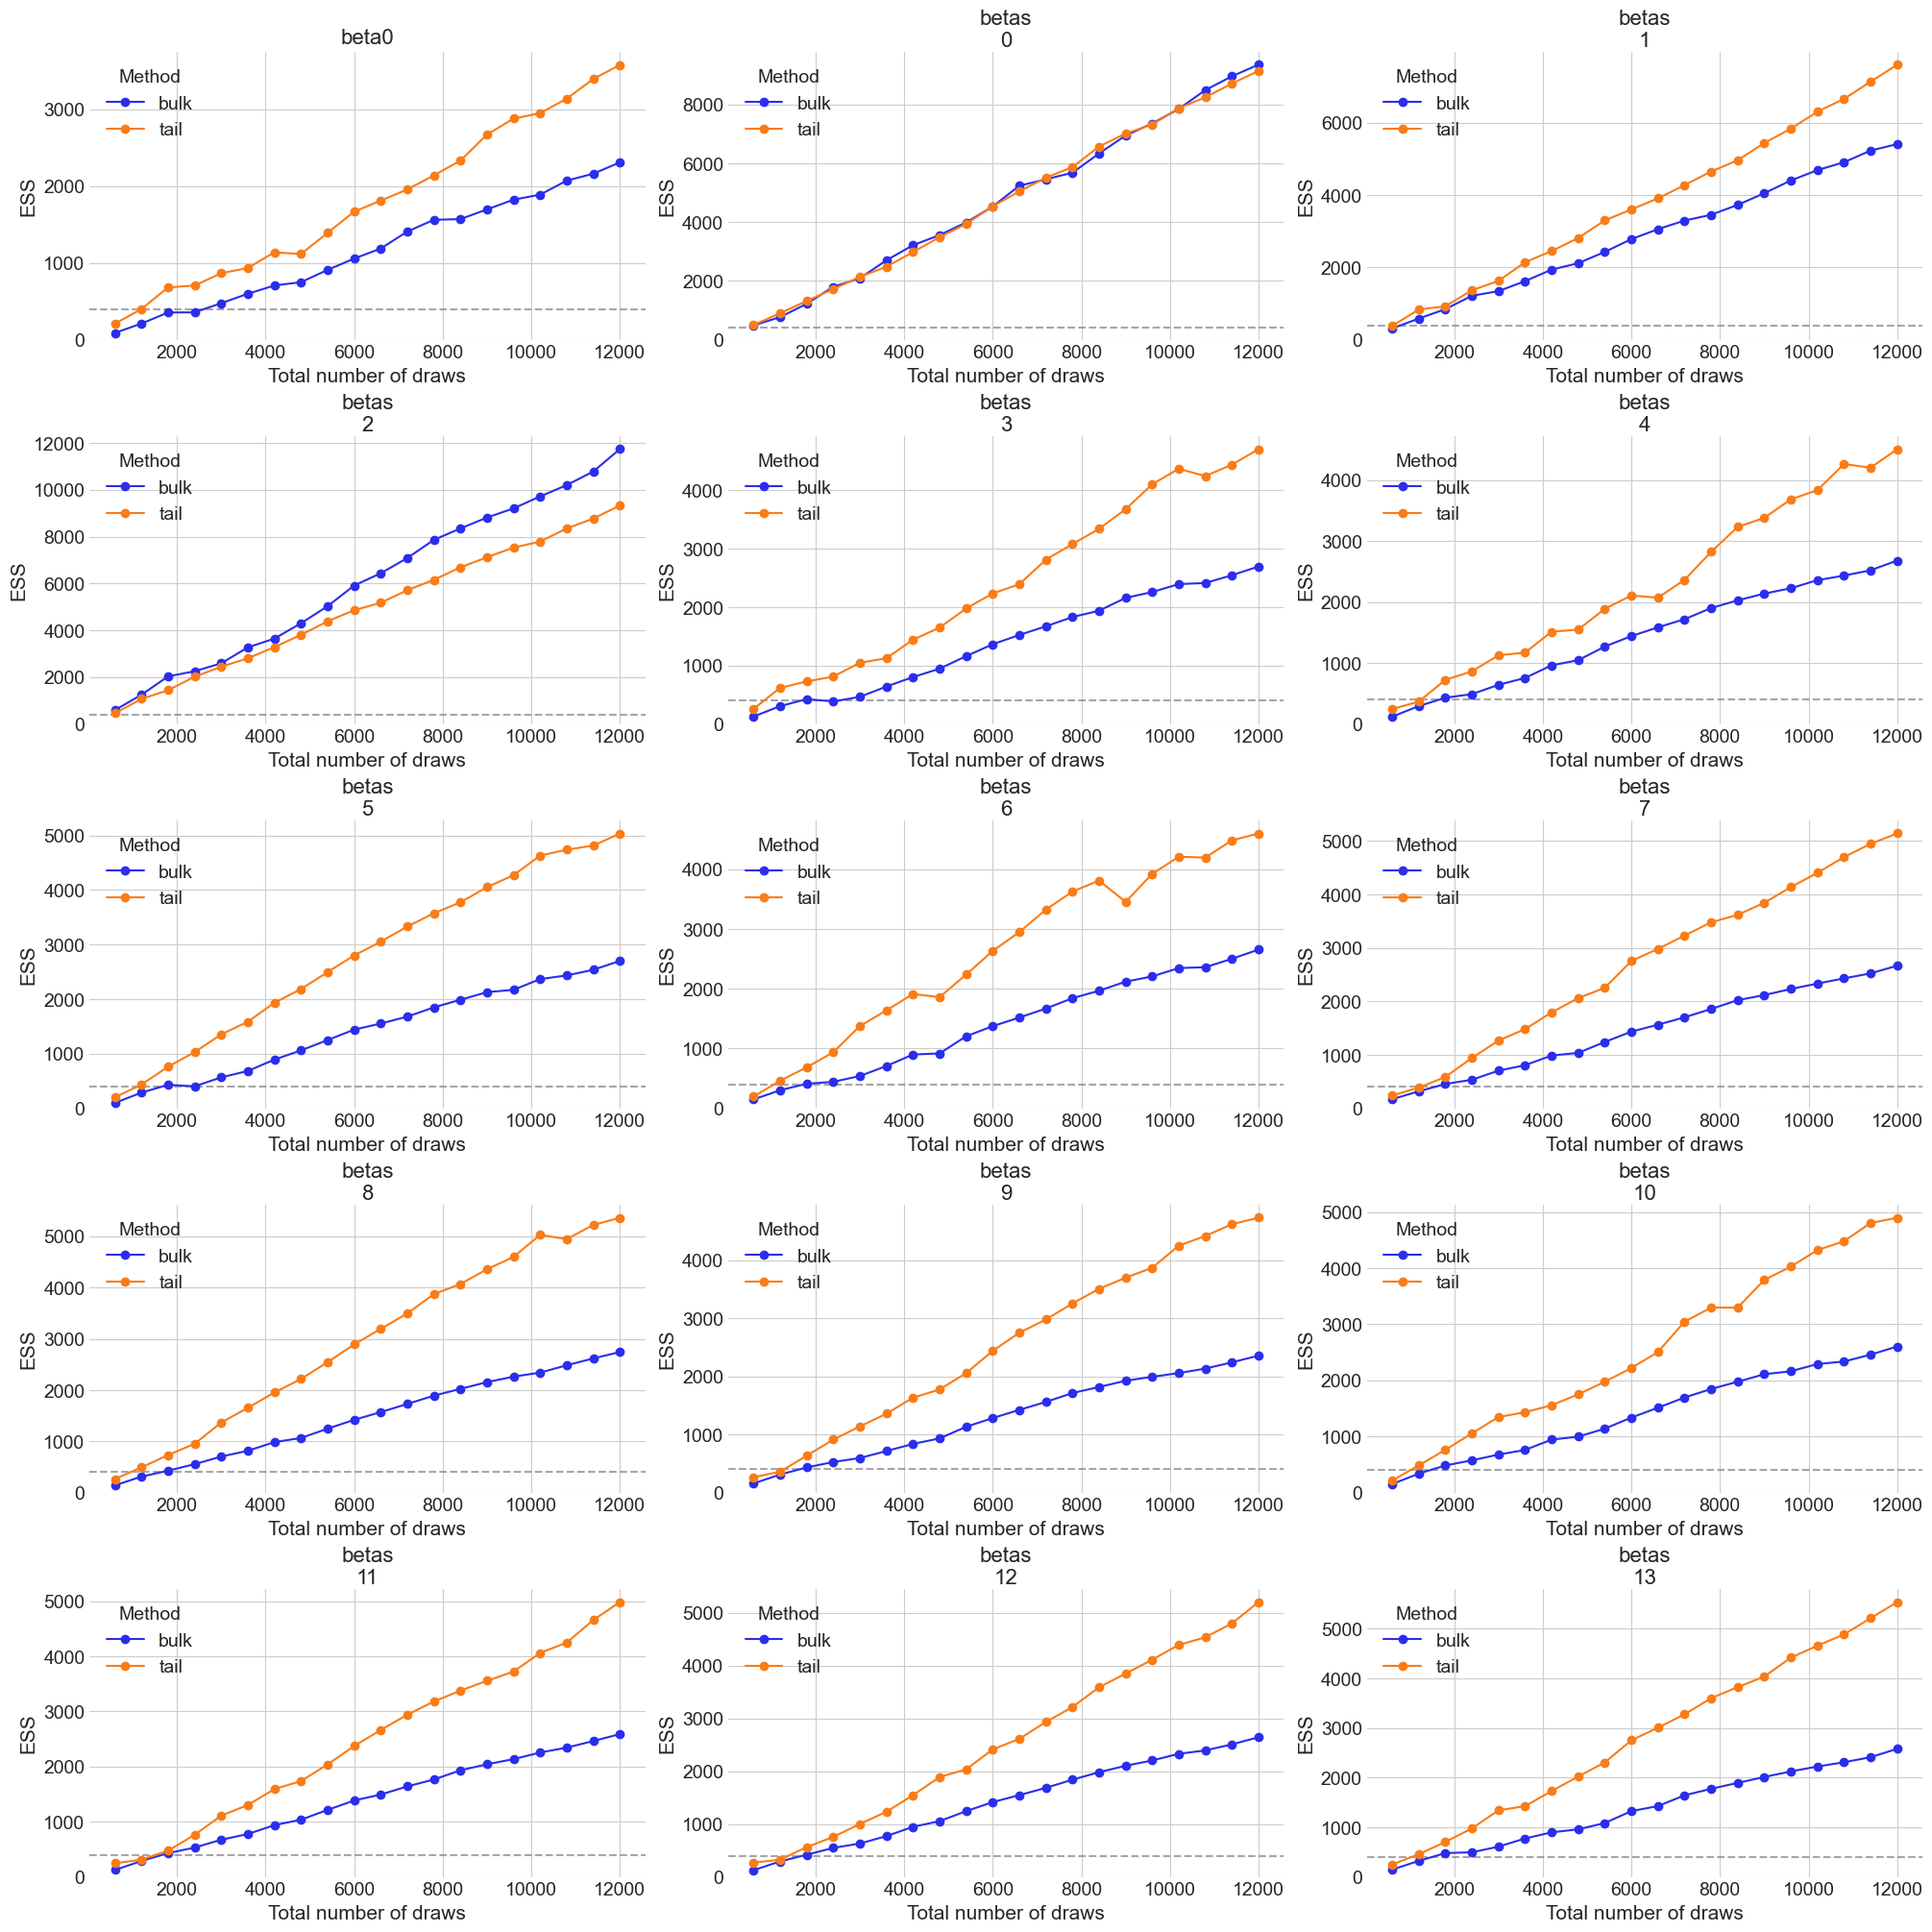

In [27]:
#Plotting effective sample size
az.plot_ess(trace, kind="evolution",figsize=(20,20))

In [28]:
#Sampling the posterior predictive
with its_model:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

Sampling: [y_obs]


Output()

<Axes: xlabel='y_obs'>

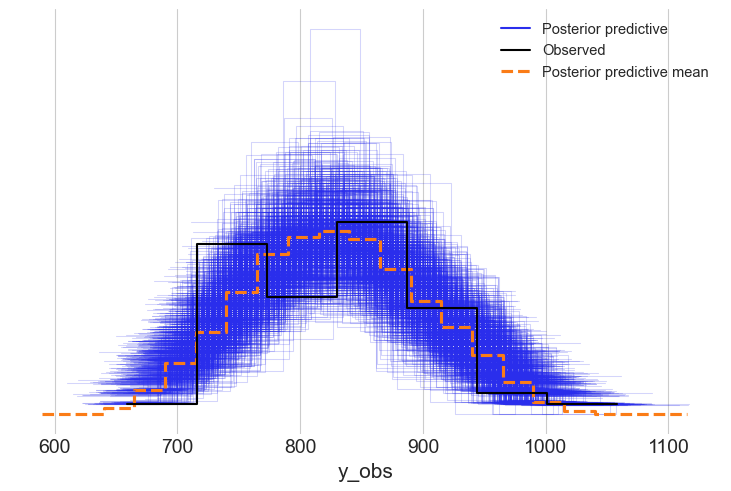

In [29]:
#Visualize posterior predictive checks
az.plot_ppc(trace, group="posterior", num_pp_samples=1000)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

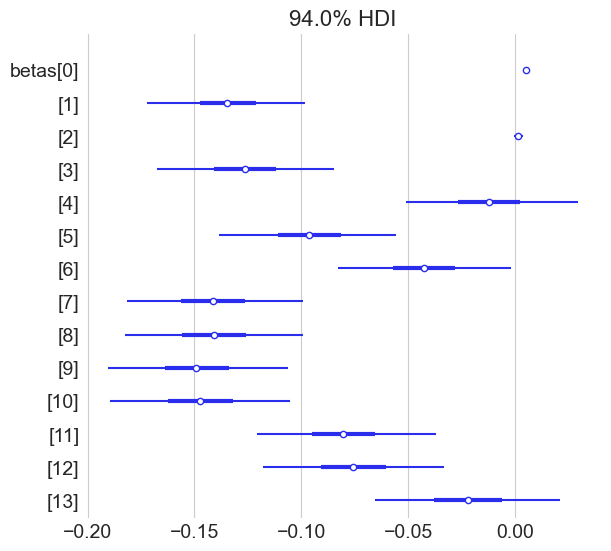

In [30]:
az.plot_forest(trace, var_names=['betas'], combined=True)

array([[<Axes: title={'center': 'betas\n0'}>,
        <Axes: title={'center': 'betas\n1'}>,
        <Axes: title={'center': 'betas\n2'}>,
        <Axes: title={'center': 'betas\n3'}>],
       [<Axes: title={'center': 'betas\n4'}>,
        <Axes: title={'center': 'betas\n5'}>,
        <Axes: title={'center': 'betas\n6'}>,
        <Axes: title={'center': 'betas\n7'}>],
       [<Axes: title={'center': 'betas\n8'}>,
        <Axes: title={'center': 'betas\n9'}>,
        <Axes: title={'center': 'betas\n10'}>,
        <Axes: title={'center': 'betas\n11'}>],
       [<Axes: title={'center': 'betas\n12'}>,
        <Axes: title={'center': 'betas\n13'}>, <Axes: >, <Axes: >]],
      dtype=object)

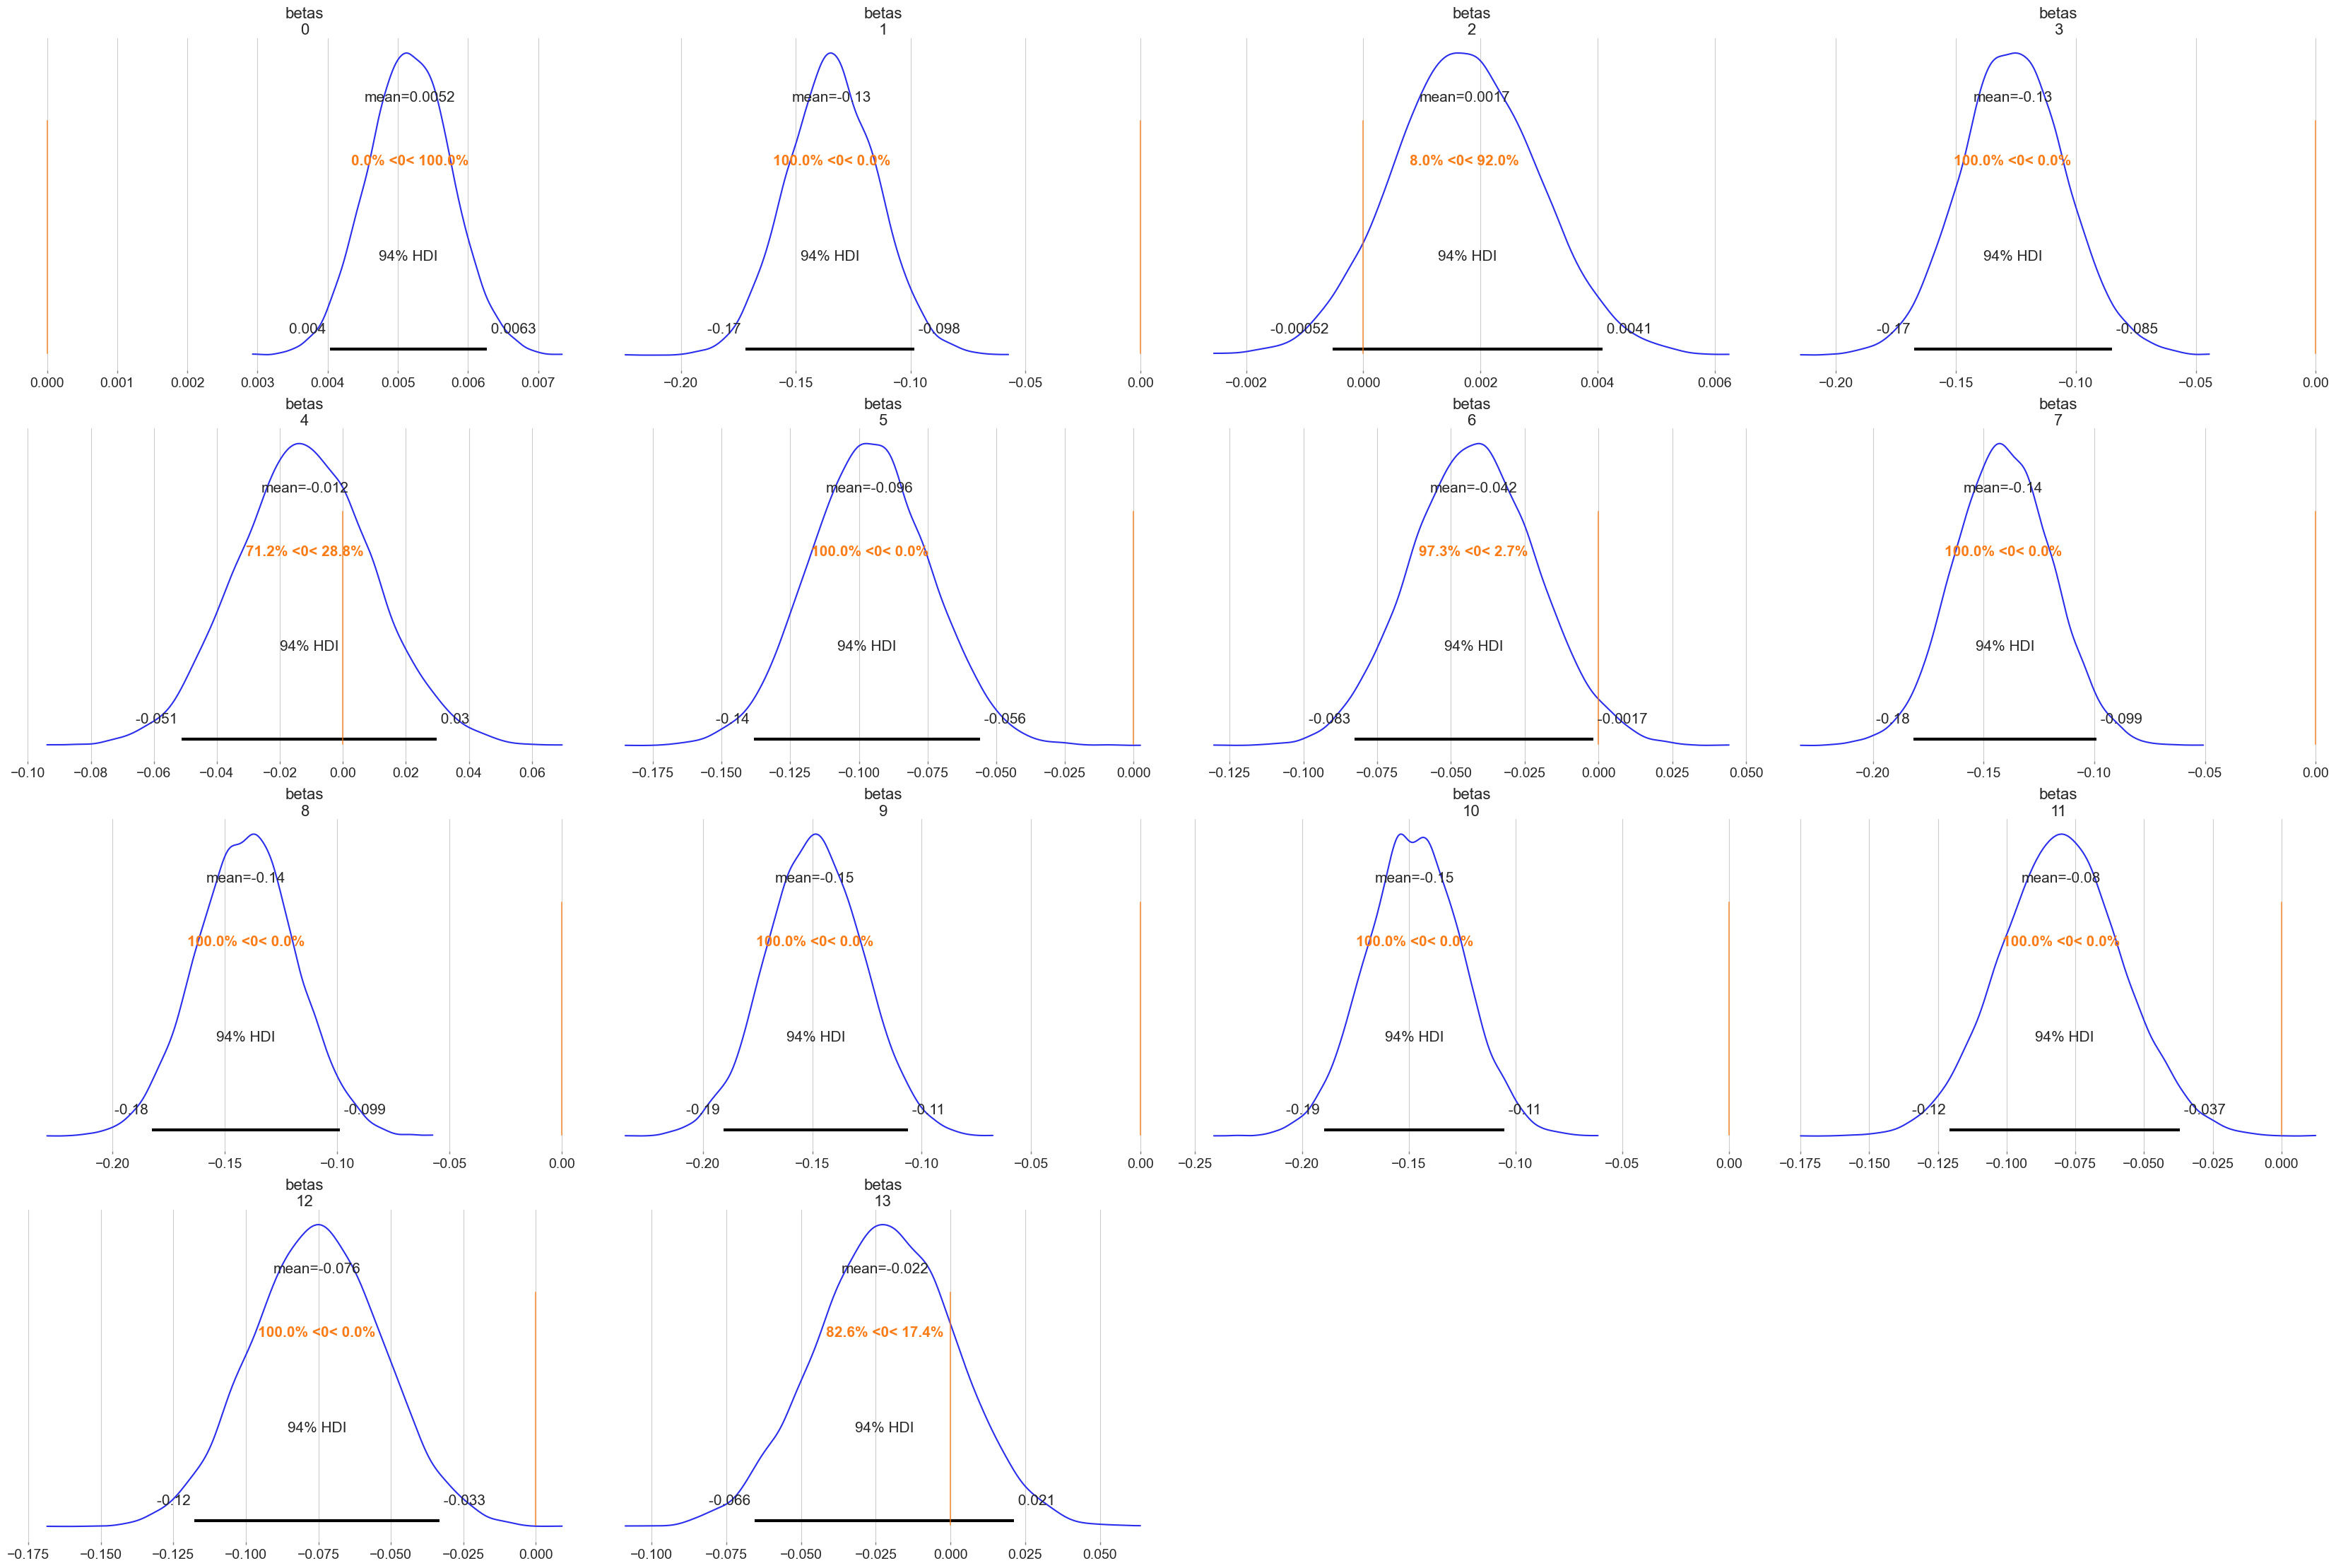

In [31]:
az.plot_posterior(trace, var_names=["betas"], ref_val=0)

Sampling: [y_obs]


Output()

Sampling: [y_obs]


Output()

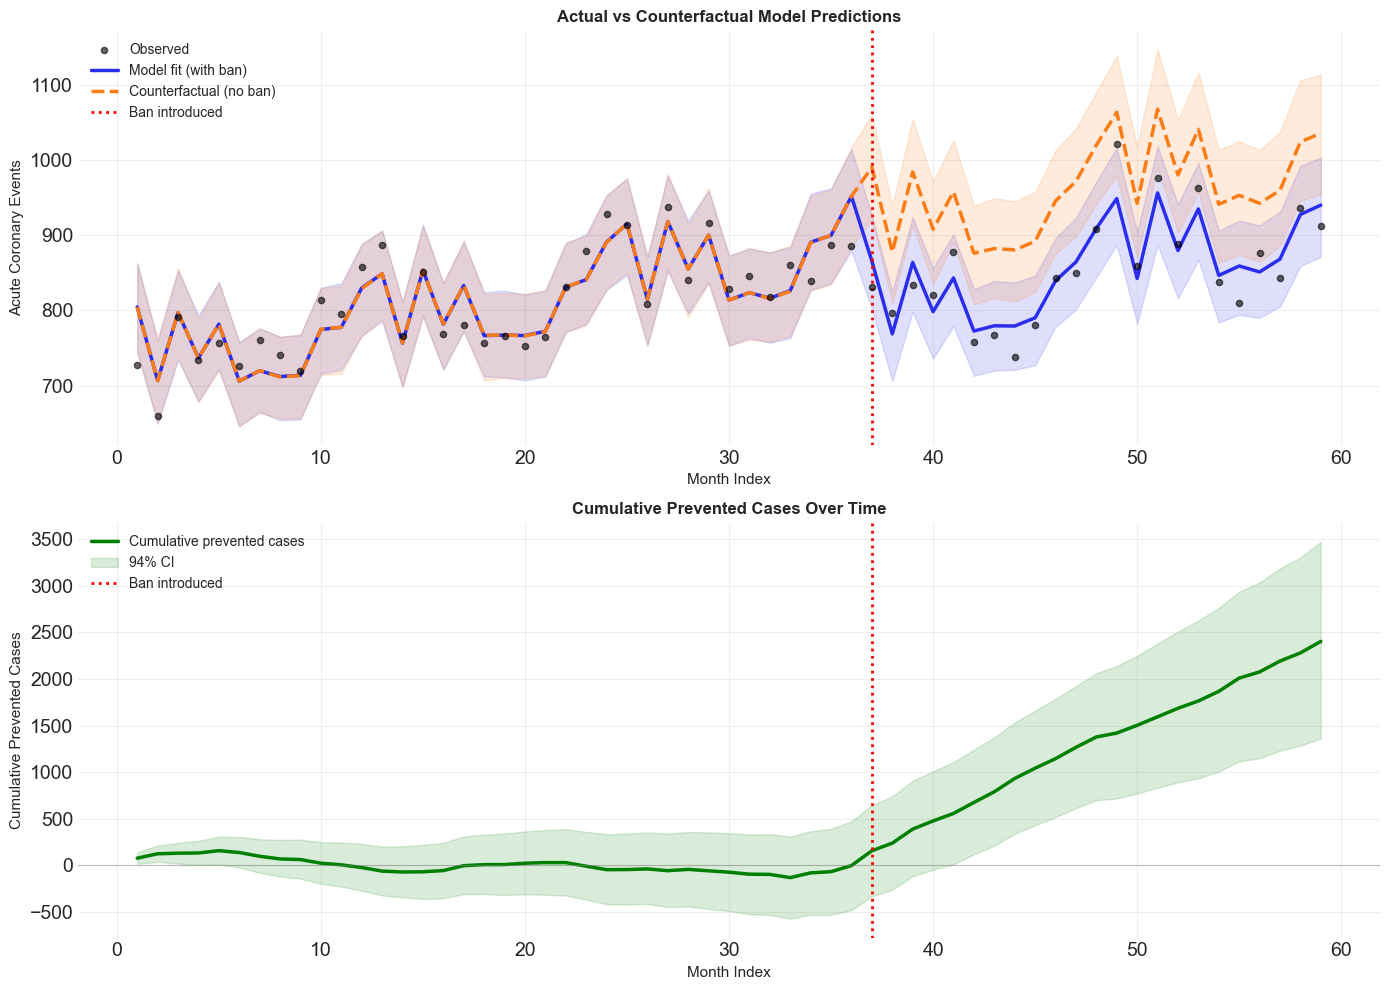

Mean prevented cases (post-ban): 2407.33175
94% CI: [1640 3274]


In [32]:
# Generate counterfactual: set smokban=0 and time_after_ban=0
df_cf = df_model.copy()
df_cf['smokban'] = 0
df_cf['time_after_ban'] = 0
X_cf = df_cf[X_columns].astype(float).values

# Sample counterfactual posterior predictive
with its_model:
    pm.set_data({'X_data': X_cf})
    post_pred_cf = pm.sample_posterior_predictive(trace, var_names=['y_obs'], return_inferencedata=True)

y_cf = post_pred_cf.posterior_predictive['y_obs']
y_cf_samples = y_cf.stack(sample=("chain", "draw")).values
y_cf_mean = y_cf_samples.mean(axis=1)
y_cf_hdi = az.hdi(y_cf, hdi_prob=0.94)
hdi_lower_cf = np.asarray(y_cf_hdi.sel(hdi="lower").to_array().values).ravel()
hdi_upper_cf = np.asarray(y_cf_hdi.sel(hdi="higher").to_array().values).ravel()

# Generate actual model fit (with intervention)
with its_model:
    pm.set_data({'X_data': X_data})
    post_pred_actual = pm.sample_posterior_predictive(trace, var_names=['y_obs'], return_inferencedata=True)

y_actual = post_pred_actual.posterior_predictive['y_obs']
y_actual_samples = y_actual.stack(sample=("chain", "draw")).values
y_actual_mean = y_actual_samples.mean(axis=1)
y_actual_hdi = az.hdi(y_actual, hdi_prob=0.94)
hdi_lower_actual = np.asarray(y_actual_hdi.sel(hdi="lower").to_array().values).ravel()
hdi_upper_actual = np.asarray(y_actual_hdi.sel(hdi="higher").to_array().values).ravel()

# Calculate prevented cases per time point
prevented_per_time = y_cf_mean - df['aces'].values
prevented_per_time_samples = y_cf_samples - df['aces'].values[:, None]

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Subplot 1: Actual vs Counterfactual
ax1.scatter(df['time'], df['aces'], color='k', s=20, alpha=0.6, label='Observed', zorder=5)
ax1.plot(df['time'], y_actual_mean, color='C0', linewidth=2.5, label='Model fit (with ban)')
ax1.fill_between(df['time'], hdi_lower_actual, hdi_upper_actual, color='C0', alpha=0.15)
ax1.plot(df['time'], y_cf_mean, color='C1', linewidth=2.5, linestyle='--', label='Counterfactual (no ban)')
ax1.fill_between(df['time'], hdi_lower_cf, hdi_upper_cf, color='C1', alpha=0.15)
ax1.axvline(ban_start_time, color='r', linestyle=':', linewidth=2, label='Ban introduced')
ax1.set_title('Actual vs Counterfactual Model Predictions', fontsize=12, fontweight='bold')
ax1.set_xlabel('Month Index', fontsize=11)
ax1.set_ylabel('Acute Coronary Events', fontsize=11)
ax1.legend(fontsize=10, loc='best')
ax1.grid(True, alpha=0.3)

# Subplot 2: Cumulative prevented cases
post_mask = df['time'] >= ban_start_time
cumulative_prevented = np.cumsum(prevented_per_time)
cumulative_prevented_samples = np.cumsum(prevented_per_time_samples, axis=0)

# Calculate quantiles for cumulative prevented
cumulative_q025 = np.quantile(cumulative_prevented_samples, 0.025, axis=1)
cumulative_q975 = np.quantile(cumulative_prevented_samples, 0.975, axis=1)

ax2.plot(df['time'], cumulative_prevented, color='green', linewidth=2.5, label='Cumulative prevented cases')
ax2.fill_between(df['time'], cumulative_q025, cumulative_q975, color='green', alpha=0.15, label='94% CI')
ax2.axvline(ban_start_time, color='r', linestyle=':', linewidth=2, label='Ban introduced')
ax2.axhline(0, color='gray', linestyle='-', linewidth=0.8, alpha=0.5)
ax2.set_title('Cumulative Prevented Cases Over Time', fontsize=12, fontweight='bold')
ax2.set_xlabel('Month Index', fontsize=11)
ax2.set_ylabel('Cumulative Prevented Cases', fontsize=11)
ax2.legend(fontsize=10, loc='best')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate total prevented cases after ban
post_mask = df['time'] >= ban_start_time
prevented_per_sample = (y_cf_samples[post_mask, :] - df.loc[post_mask, 'aces'].values[:, None]).sum(axis=0)
print('Mean prevented cases (post-ban):', prevented_per_sample.mean())
print('94% CI:', az.hdi(prevented_per_sample, hdi_prob=0.94))